## Assignment 2:

The goal is to compare `dense neural networks` and `convolutional neural networks` on `Fashion mnist` data.



In all the experiments, we would hold some parameters constants - the batch size to 100, the number of epochs to 20, same optimizer, same loss function of cross entropy, so that we can do fair comparisons. 



* **EXPERIMENT 1: DNN with 2 layers (no drop out)**

* **EXPERIMENT 2: DNN with 3 layers (no drop out)**

* EXPERIMENT 3: CNN with 2 convolution/max pooling layers (no drop out)

* EXPERIMENT 4: CNN with 3 convolution/max pooling layers (no drop out)

* EXPERIMENT 5: Redo all the 4 experiments with 20% drop out

`Result1`:  Create a table with the accuracy and loss for train/test/validation & process time for all the 8 models

`Result2`: Take `EXPERIMENT 3` – Extract the outputs from 2 selected filters from the 2 max pooling layers and visualize them in a grid as images. See whether the 'lit up' regions correspond to some features in the original images.

**Note:** This page might be a useful reference: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=en#setup (as well as the other tutorials on their site).


We use `callbacks` below to get the training (+ validation?) runtimes though we could have just timed `model.fit(...)`. See https://keras.io/callbacks/

## Import packages needed (and set seed)

Since Keras in part of TensorFlow 2.x, we import keras from tensorflow and use tenserflow.keras.xxx to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.2.4-tf'

In [2]:
tf.__version__

'2.1.0'

In [3]:
# To get consistint results each time we rerun the code.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## The Fashion MNIST dataset

Zalando is Europe's leading online fashion platform for women, men and children. `Fashion-MNIST` is a dataset of their product images. Just like `MNIST` dataset, the `Fashion-MNIST` also consists of 70,000 grayscale images of 28x28 pixels divided into 60,000 training images and 10,000 test images. Each image is labeled with with an integer from 0 to 9 representing 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', respectively. `Fashion-MNIST` is intended to serve as a direct drop-in replacement for the original `MNIST` dataset for benchmarking machine learning algorithms since the the original `MNIST` was found to be too easy for the current machine learning models. In particular, Fashion-Mist shares the same image size and structure of training and testing splits as `MNIST`. Also like `MNIST` it comes prepackaged in `tf.Keras`. Use

```python
fashion_mnist.load_data()
```

to the get these datasets (and the corresponding labels) as Numpy arrays. See the `Fashion-MNIST` GitHub page for a lot more information about the data sets and benchmarks for 129 classifiers trained on the data:

https://github.com/zalandoresearch/fashion-mnist

In [4]:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images.shape, test_images.shape, test_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (10000,), (10000,))

In [5]:
from collections import Counter
Counter(train_labels).most_common()

[(9, 6000),
 (0, 6000),
 (3, 6000),
 (2, 6000),
 (7, 6000),
 (5, 6000),
 (1, 6000),
 (6, 6000),
 (4, 6000),
 (8, 6000)]

In [6]:
# https://github.com/zalandoresearch/fashion-mnist
# https://www.tensorflow.org/tutorials/keras/classification

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

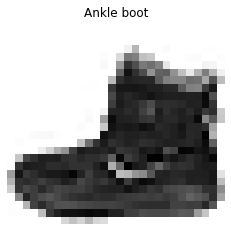

In [7]:
import matplotlib.pyplot as plt
#https://matplotlib.org/tutorials/colors/colormaps.html?highlight=colormap
plt.imshow(train_images[0], cmap="binary") 
plt.axis('off')
plt.title(class_names[test_labels[0]], fontsize=12)
plt.show()

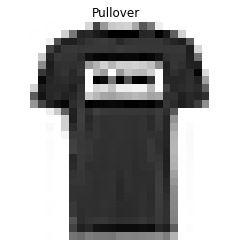

In [8]:
import matplotlib.pyplot as plt
plt.imshow(train_images[1], cmap="binary") 
plt.axis('off')
plt.title(class_names[test_labels[1]], fontsize=12)
plt.show()

# EXPERIMENT  1:

We will use the 'best' `DNN` model from assignment 1. The model will consist of 784 input nodes, a hidden layer with `5 nodes` and 10 output nodes (corresponding to the 10 fashion categories).

We use `fashion_mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. After training the model, we use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

## Preparing the data

Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the \[0, 1] interval.

Our training images are stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. 

We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1.

**N.B**: Changed my mind and used a Flatten layer in the model showing two ways of doing this.

In [9]:
# We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1. 

#train_images = train_images.reshape((60000, 28 * 28))  # Decided instead to use a Flatten layer in the model
train_images = train_images.astype('float32') / 255

#test_images = test_images.reshape((10000, 28 * 28))  # Decided instead to use a Flatten layer in the model
test_images = test_images.astype('float32') / 255

## Validating our approach

We set apart 5,000 samples of our training data to use as a validation set. Since we will be using `sparse_categorical_crossentropy` as the loss function we **do not** need to use `to_categorical` to convert the class vector of labels to binary matrix representation.

In [10]:
# Create validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Building our network

Here our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 

The first `Dense` layer, the hidden layer, consists of `five nodes`.

The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of our 10 classes.

In [11]:
# from tensorflow.keras import models
# from tensorflow.keras import layers

# model = models.Sequential()
# model.add(layers.Dense(5, activation='relu', input_shape=(28 * 28,)))
# model.add(layers.Dense(10, activation='softmax'))   

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Flatten(input_shape=[28, 28]))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(10, activation='softmax')) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 3925      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                60        
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


In [13]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.InputLayer(input_shape=[28, 28]))
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(10, activation='softmax')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 3925      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                60        
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


## Compiling the model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [14]:
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Creating a callback to get training times

In [15]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

## Training the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [16]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 1s 19us/sample - loss: 1.3400 - accuracy: 0.5334 - val_loss: 0.9931 - val_accuracy: 0.6592
Epoch 2/20
55000/55000 [==============================] - 1s 13us/sample - loss: 0.8117 - accuracy: 0.7376 - val_loss: 0.6585 - val_accuracy: 0.7876
Epoch 3/20
55000/55000 [==============================] - 1s 14us/sample - loss: 0.6103 - accuracy: 0.7955 - val_loss: 0.5716 - val_accuracy: 0.8120
Epoch 4/20
55000/55000 [==============================] - 1s 12us/sample - loss: 0.5602 - accuracy: 0.8095 - val_loss: 0.5577 - val_accuracy: 0.8136
Epoch 5/20
55000/55000 [==============================] - 1s 13us/sample - loss: 0.5355 - accuracy: 0.8167 - val_loss: 0.5289 - val_accuracy: 0.8212
Epoch 6/20
55000/55000 [==============================] - 1s 13us/sample - loss: 0.5195 - accuracy: 0.8212 - val_loss: 0.5090 - val_accuracy: 0.8294
Epoch 7/20
55000/55000 [==============================] -

In [17]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

14.524087

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [18]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [19]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])

10000/10000 [==============================] - 0s 34us/sample - loss: 0.5039 - accuracy: 0.8259


In [20]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.344672

## Creating a DataFrame for the training and test statistics

We will create a pandas DataFrame to hold the training/test times and their accuracy and loss values of each of the four models (and their variations) that we will consider in these experiment. We add the statistics for our first model to that DataFrame.

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.463088,0.840182,0.467211,0.8454
16,0.459666,0.841600,0.472976,0.8432
17,0.458067,0.841455,0.465934,0.8458
18,0.456473,0.842873,0.472170,0.8438
19,0.454319,0.842818,0.471372,0.8414


In [23]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (2 layers)') # went the model name to appear first
results_df['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,DNN (2 layers),0.454319,0.842818,0.471372,0.8414,14.524087,0.344672


## Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

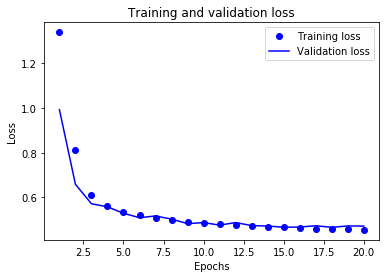

In [24]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

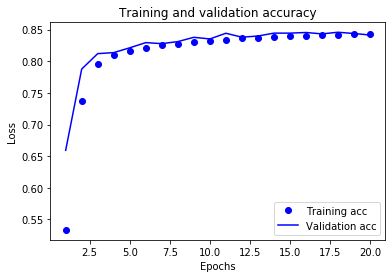

In [25]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# EXPERIMENT  2:

This time our `DNN` model will consist of 784 input nodes, a hidden layer with `10 nodes`, another hidden layer with a hidden layer with `5 nodes` and 10 output nodes (corresponding to the 10 fashion categories).

We use `fashion_mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. After training the model, we use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [26]:
# model = models.Sequential()


# model.add(layers.Flatten(input_shape=[28, 28]))
# model.add(layers.Dense(10, activation='relu'))
# model.add(keras.layers.Dense(5, activation="relu"))
# model.add(layers.Dense(10, activation='softmax'))  

In [27]:
# nstead of adding the layers one by one, we can pass a list of layers when creating the Sequential mode.
model = models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                60        
Total params: 7,965
Trainable params: 7,965
Non-trainable params: 0
_________________________________________________________________


## Compiling the model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [29]:
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Training the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [30]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 1s 19us/sample - loss: 1.0735 - accuracy: 0.6615 - val_loss: 0.6312 - val_accuracy: 0.8034
Epoch 2/20
55000/55000 [==============================] - 1s 12us/sample - loss: 0.5850 - accuracy: 0.8100 - val_loss: 0.5362 - val_accuracy: 0.8262
Epoch 3/20
55000/55000 [==============================] - 1s 13us/sample - loss: 0.5201 - accuracy: 0.8268 - val_loss: 0.4935 - val_accuracy: 0.8370
Epoch 4/20
55000/55000 [==============================] - 1s 12us/sample - loss: 0.4868 - accuracy: 0.8351 - val_loss: 0.4979 - val_accuracy: 0.8316
Epoch 5/20
55000/55000 [==============================] - 1s 16us/sample - loss: 0.4664 - accuracy: 0.8412 - val_loss: 0.4545 - val_accuracy: 0.8476
Epoch 6/20
55000/55000 [==============================] - 1s 15us/sample - loss: 0.4529 - accuracy: 0.8449 - val_loss: 0.4495 - val_accuracy: 0.8456
Epoch 7/20
55000/55000 [==============================] -

In [31]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

16.43647

In [32]:
model.layers[1].weights

[<tf.Variable 'dense_4/kernel:0' shape=(784, 10) dtype=float32, numpy=
 array([[ 0.05579777,  0.05761431,  0.11842335, ..., -0.06174219,
         -0.07457855,  0.18403842],
        [ 0.06744194, -0.25297812, -0.4632916 , ...,  0.15222494,
          0.1854762 , -0.40126863],
        [-0.08618518, -0.08550449,  0.3783135 , ...,  0.26771116,
          0.25437564,  0.39628905],
        ...,
        [ 0.28355807,  0.09156384, -0.49695656, ...,  0.45688406,
          0.05001352, -0.45005202],
        [-0.02745122,  0.18720807, -0.32171783, ...,  0.1458758 ,
          0.0554604 , -0.46066982],
        [-0.05342789, -0.08436459, -0.17975271, ...,  0.2934471 ,
          0.12588562, -0.29630825]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(10,) dtype=float32, numpy=
 array([ 0.6771059 ,  0.18796849, -0.02073851,  0.5782038 ,  0.22776678,
         0.5888107 ,  0.10112922,  0.7547444 , -0.46303672,  0.40301085],
       dtype=float32)>]

## Testing the model

We are now ready to train our network, which in Keras is done via a call to the `evaluate` method of the network. Also we pass the method the callback object we create to get the total testing time.

In [45]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])

10000/10000 [==============================] - 0s 27us/sample - loss: 0.4453 - accuracy: 0.8470


In [46]:
model.layers[1].weights

[<tf.Variable 'dense_4/kernel:0' shape=(784, 10) dtype=float32, numpy=
 array([[ 0.05579777,  0.05761431,  0.11842335, ..., -0.06174219,
         -0.07457855,  0.18403842],
        [ 0.06744194, -0.25297812, -0.4632916 , ...,  0.15222494,
          0.1854762 , -0.40126863],
        [-0.08618518, -0.08550449,  0.3783135 , ...,  0.26771116,
          0.25437564,  0.39628905],
        ...,
        [ 0.28355807,  0.09156384, -0.49695656, ...,  0.45688406,
          0.05001352, -0.45005202],
        [-0.02745122,  0.18720807, -0.32171783, ...,  0.1458758 ,
          0.0554604 , -0.46066982],
        [-0.05342789, -0.08436459, -0.17975271, ...,  0.2934471 ,
          0.12588562, -0.29630825]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(10,) dtype=float32, numpy=
 array([ 0.6771059 ,  0.18796849, -0.02073851,  0.5782038 ,  0.22776678,
         0.5888107 ,  0.10112922,  0.7547444 , -0.46303672,  0.40301085],
       dtype=float32)>]

In [35]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.347705

# Adding the statistics to our results DataFrame

We add the performance statistics for the new model to our DataFrame.

In [36]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
results_df2 = history_df.iloc[-1:].copy()
results_df2.insert(0,'model','DNN (3 layers)') # went the model name to appear first
results_df2['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df2['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df2

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,DNN (3 layers),0.38776,0.864018,0.412788,0.859,16.43647,0.347705


In [37]:
results_df=results_df.append(results_df2,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.454319,0.842818,0.471372,0.8414,14.524087,0.344672
1,DNN (3 layers),0.387760,0.864018,0.412788,0.8590,16.436470,0.347705


## Saving our DataFrame to disk

We pickle the DataFrame so that we keep adding to it Experiment 3.

In [38]:
results_df.to_pickle("results.pkl") # save the DataFrame to use in Part 2

## Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

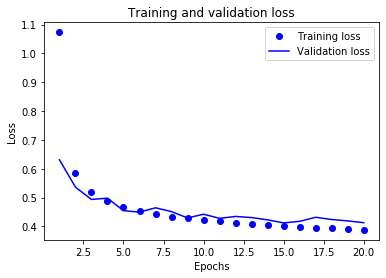

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

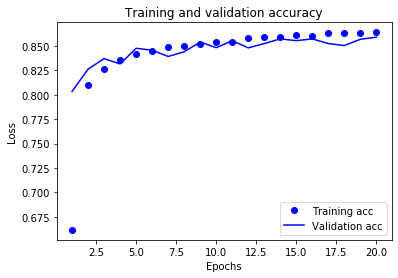

In [40]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [41]:
from tensorflow.keras.metrics import sparse_categorical_accuracy, categorical_accuracy

In [42]:
sparse_categorical_accuracy(np.array([3]),np.array([0,0,0,1]))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [43]:
categorical_accuracy(np.array([0,0,0,1]),np.array([0,0,0,1]))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [44]:
history.epochs

AttributeError: 'History' object has no attribute 'epochs'